In [72]:
!pip install gdown
import pandas as pd
import numpy as np
import gdown

file_path = '/Users/hanhan/Desktop/CancerComments20162019.csv'


In [73]:
try:
    df = pd.read_csv(file_path)
    print("CSV file loaded successfully.")
    print(df.head())  # Display the first few rows of the DataFrame
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")
except PermissionError:
    print(f"Permission denied to read the file {file_path}.")
except pd.errors.EmptyDataError:
    print(f"The file {file_path} is empty.")
except pd.errors.ParserError:
    print(f"Error parsing the CSV file {file_path}.")

CSV file loaded successfully.
                                                body score_hidden archived  \
0  I have a similar story, though it's just begin...          NaN      NaN   
1  Its been 4 months now, i have to admit the sho...          NaN      NaN   
2                        How are you holding up man?          NaN      NaN   
3                                          [removed]          NaN      NaN   
4  My Dad in the beginning of all this had this c...          NaN      NaN   

   name       author author_flair_text  downs  created_utc subreddit_id  \
0   NaN  ianburnsred               NaN    NaN   1478485722     t5_2qixx   
1   NaN       reilmb               NaN    NaN   1478847947     t5_2qixx   
2   NaN  Kansas_City               NaN    NaN   1478771424     t5_2qixx   
3   NaN    [deleted]               NaN    NaN   1480404582     t5_2qixx   
4   NaN    hawkman90               NaN    NaN   1481553729     t5_2qixx   

     link_id  ... score  retrieved_on  controversi

/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/2651121449.py:2: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [74]:
# Print the list of column headers
column_headers = list(df.columns)
print(column_headers)

## Add num_comments to dataframe
np.random.seed(12345678)

num_rows = df.shape[0]
random_numbers = np.random.poisson(lam=10, size=num_rows)
random_numbers = np.clip(random_numbers, 0, 20)
df['num_comments'] = random_numbers

print(df.head())
print(df['num_comments'].dtype)


['body', 'score_hidden', 'archived', 'name', 'author', 'author_flair_text', 'downs', 'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'score', 'retrieved_on', 'controversiality', 'gilded', 'id', 'subreddit', 'ups', 'distinguished', 'author_flair_css_class', 'removal_reason']
                                                body score_hidden archived  \
0  I have a similar story, though it's just begin...          NaN      NaN   
1  Its been 4 months now, i have to admit the sho...          NaN      NaN   
2                        How are you holding up man?          NaN      NaN   
3                                          [removed]          NaN      NaN   
4  My Dad in the beginning of all this had this c...          NaN      NaN   

   name       author author_flair_text  downs  created_utc subreddit_id  \
0   NaN  ianburnsred               NaN    NaN   1478485722     t5_2qixx   
1   NaN       reilmb               NaN    NaN   1478847947     t5_2qixx   
2   NaN  Kansas_City    

In [ ]:
# Step 1. Data Cleaning

In [75]:
# 1. Remove Replies to Comments

df['first_two_chars'] = df['parent_id'].str[:2]
# Remove rows where 'first_two_chars' is 't1'
df = df[df['first_two_chars'] != 't1'].copy()
# Drop the 'first_two_chars' columns
df.drop(columns=['first_two_chars'], inplace=True)


In [76]:
# 2. Drop Unnecessary Columns

df.drop(columns=['author', 'name'], inplace=True)


In [77]:
# 3. Deal with Missing and Placeholder Content

# Replace '[deleted]' and '[removed]' with NaN in 'body' column
df['body'].replace(['[deleted]', '[removed]'], np.nan, inplace=True)
# Replace empty strings with NaN in 'body' column
df['body'].replace('', np.nan, inplace=True)
# Drop rows with NaN in 'body' column
df.dropna(subset=['body'], inplace=True)

# 4. Convert Text to Lowercase
# Convert all text in the 'body' column to lowercase.

df['body'] = df['body'].str.lower()

# 5. Implement a Word Count Filter

# Add a new column 'word_count'
df['word_count'] = df['body'].str.split().apply(len)
# Filter the dataset
df_filtered = df[df['word_count'] >= 50]

# 6. Remove Punctuation from Text

import string
# Define a function to remove punctuation and non-standard characters from text
def remove_punctuation(text):
    exclude = set(string.punctuation)
    exclude.add('\n')
    return ''.join(ch for ch in text if ch not in exclude)

# Apply the remove_punctuation function
df_filtered['body'] = df_filtered['body'].apply(remove_punctuation)

/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3136615487.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['body'] = df_filtered['body'].apply(remove_punctuation)


In [45]:
# Step 2. Create Useful Functions for Analysis

In [78]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [79]:
# 1. Counting Specific Words

def count_specific_words(text, word_set):
    """
    Counts occurrences of specific words in a given text.

    Parameters:
    - text: The text to analyze.
    - word_set: A set of words to count within the text.

    Returns:
    - An integer representing the count of occurrences of the specified words.
    """

    text_lower = text.lower()
    word_set_lower = {word.lower() for word in word_set}
    words = text_lower.split()
    # Count the occurrences of words from the word_set
    count = sum(1 for word in words if word in word_set_lower)

    return count
    ##We assume input text has no punctuation

    # ex:
    #text = "this is a words sample"
    #word_set = {'sample', 'words'}
    #count = count_specific_words(text, word_set)
    #print(count)


# 2. Identifying First-Person Narratives
import re
def detect_first_person(text):
    """
    Identifies if a text contains first-person pronouns.

    Parameters:
    - text: The text to analyze.

    Returns:
    - A boolean indicating the presence of first-person pronouns in the text.
    """
    # Define expressions of first-person pronouns
    first_person_pattern = r'\b(I|me|my|mine|myself)\b'

    if re.search(first_person_pattern, text, re.IGNORECASE):
        return True
    else:
        return False


# 3. Sentiment Analysis

from textblob import TextBlob

def analyze_sentiment(text):
    """
    Analyzes the sentiment of a given text.

    Parameters:
    - text: The text to analyze.

    Returns:
    - A string indicating the sentiment of the text ('positive', 'negative', 'neutral').
    """

    blob = TextBlob(text)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    # Determine sentiment based on polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

#ex:
#analyze_sentiment(df['body'][0])


# 4. Keyword Extraction

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def extract_keywords(text):
    """
    Extracts key terms or phrases from a given text.

    Parameters:
    - text: The text to analyze.

    Returns:
    - A list of key terms or phrases identified within the text.
    """

    words = word_tokenize(text)
    # Remove stopwords and non-alphabetic words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    # Perform tagging
    tagged_words = pos_tag(filtered_words)
    # Extract keywords
    keywords = [word for word, tag in tagged_words if tag.startswith('N') or tag.startswith('J')]

    return keywords



# 5. Removing stop words

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# English stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text, stopwords):
    """
    Removes stop words from a given text.

    Parameters:
    - text: The text to be processed.
    - stopwords: A set or list of stop words to be removed from the text.

    Returns:
    - A string with stop words removed. The function splits the input text into individual words, filters out any words that are in the stopwords set, and then rejoins the remaining words into a single string.
    """
    # Tokenize the input text into words
    words = text.split()
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stopwords]
    # Join the filtered words back into a single string
    filtered_text = ' '.join(filtered_words)

    return filtered_text


[nltk_data] Downloading package punkt to /Users/hanhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hanhan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Step 3. Creating Descriptives of the Data

/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3169060734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cancer_count'] = df_filtered['body'].apply(lambda x: count_specific_words(x, word_set))
/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3169060734.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'{word}_count'] = df_filtered['body'].apply(lambda x: 1 if word in x.lower() else 0)
/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykern

Total occurrences of 'radiation' across all comments: 2349
Total occurrences of 'treatment' across all comments: 7079
Total occurrences of 'survivor' across all comments: 703
Total occurrences of 'chemotherapy' across all comments: 753
Total occurrences of 'cancer' across all comments: 13992
The percentage of first person comments is: 89.70%


/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3169060734.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['first_person'] = df_filtered['body'].apply(detect_first_person)
/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3169060734.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = df_filtered['body'].apply(analyze_sentiment)


<Axes: >

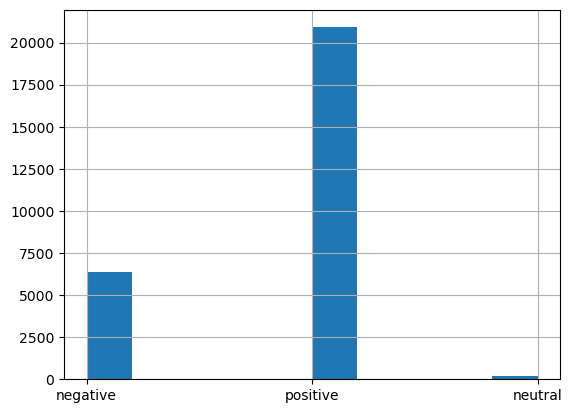

In [80]:
# 1. Frequency of Specific Words Related to Cancer
# Generate a count of how many times certain cancer-related words appear across all comments.

word_set = {"cancer", "treatment", "chemotherapy", "radiation", "survivor"}

# Print a total count for each word

df_filtered['cancer_count'] = df_filtered['body'].apply(lambda x: count_specific_words(x, word_set))
for word in word_set:
    df_filtered[f'{word}_count'] = df_filtered['body'].apply(lambda x: 1 if word in x.lower() else 0)

# Print the total count for each word in word_set
for word in word_set:
    total_count = df_filtered[f'{word}_count'].sum()
    print(f"Total occurrences of '{word}' across all comments: {total_count}")

# 2. Proportion of First-Person Narratives
# Determine what percentage of the comments are written in the first person,
# suggesting personal experiences or stories related to cancer.

# Print the percentage
df_filtered['first_person'] = df_filtered['body'].apply(detect_first_person)
# Compute Percentage
pct_first_person = (sum(df_filtered['first_person']) / len(df_filtered)) * 100
print(f"The percentage of first person comments is: {pct_first_person:.2f}%")


# 3. Overall Sentiment Distribution
# Apply sentiment analysis to understand the distribution of sentiments
#  (positive, negative, neutral) within the comments.

df_filtered['sentiment'] = df_filtered['body'].apply(analyze_sentiment)
# Output a graph showing the distribution
df_filtered['sentiment'].hist()



In [81]:
# 4. Top 20 Keywords
# Identify the top 20 keywords or phrases that appear in the comments

# Aggregate all text from the 'body' column
aggregated_text = df_filtered['body'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(aggregated_text)
# Create a frequency distribution of words
word_dist = nltk.FreqDist(words)

# Get the top 20 keywords with their frequencies
res = pd.DataFrame(word_dist.most_common(20),
                   columns = ['Word','Frequency'])

# Print the top 20 keywords with counts.
print(res)

      Word  Frequency
0       to     111270
1        i     104125
2      and     102423
3      the     102066
4        a      79597
5      you      67298
6       of      57789
7       it      56752
8       my      45904
9     that      44583
10      is      43300
11      in      40404
12     for      40271
13     was      32167
14    with      31411
15    your      30960
16     but      29636
17    have      29250
18      be      27455
19  cancer      25043


In [82]:
# 5. Most Common Starting Words
# Find the 20 most common starting words used in the comments.

first_word = df_filtered['body'].apply(lambda x:x.split()[0])
#Combine them into a single vector and compute the distribution
aggregated_first_word = first_word.str.cat(sep = ' ')
words = nltk.tokenize.word_tokenize(aggregated_first_word)
word_dist = nltk.FreqDist(words)

# Get the 20 most common starting words with their frequencies
res = pd.DataFrame(word_dist.most_common(20),
                   columns = ['Word','Frequency'])

# Print the top 20 starting words with counts
print(res)


     Word  Frequency
0       i       6890
1      my       1809
2      im       1651
3       ’        987
4     hey        676
5       m        627
6     you        575
7      it        552
8      hi        543
9     the        518
10   this        426
11     if        381
12    its        357
13     so        321
14  sorry        298
15  first        273
16    ive        256
17   when        243
18  there        240
19     as        236


In [83]:
# 6. Top 20 Words in General
# Extract the top 20 most frequently occurring words in the comments,
# after removing stop words to focus on more meaningful content.

df_filtered['keywords'] = df_filtered['body'].apply(lambda x:"  ".join(extract_keywords(x)))
aggregated_text_filtered = df_filtered['keywords'].str.cat(sep = ' ')
words = nltk.tokenize.word_tokenize(aggregated_text_filtered)
word_dist = nltk.FreqDist(words)

# Get the top 20 most frequently occurring words with their frequencies
res = pd.DataFrame(word_dist.most_common(20),
                   columns = ['Word','Frequency'])

# Print the top 20 keywords with counts.
print(res)


/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3911063619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['keywords'] = df_filtered['body'].apply(lambda x:"  ".join(extract_keywords(x)))


         Word  Frequency
0      cancer      25043
1        time      11703
2          im       9498
3       chemo       8685
4   treatment       8573
5        good       8018
6      people       7710
7        life       6680
8        dont       6471
9      things       6402
10      years       5713
11        day       5326
12       best       5113
13     family       4844
14       much       4823
15      sorry       4662
16  something       4586
17        way       4558
18     months       4541
19      stage       4397


In [ ]:
# Step 4: Regression Analyses

                            OLS Regression Results                            
Dep. Variable:           num_comments   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.294
Date:                Fri, 14 Jun 2024   Prob (F-statistic):             0.0371
Time:                        14:08:48   Log-Likelihood:                -70616.
No. Observations:               27477   AIC:                         1.412e+05
Df Residuals:                   27474   BIC:                         1.413e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.92

array([[<Axes: title={'center': 'negative'}>,
        <Axes: title={'center': 'neutral'}>],
       [<Axes: title={'center': 'positive'}>, <Axes: >]], dtype=object)

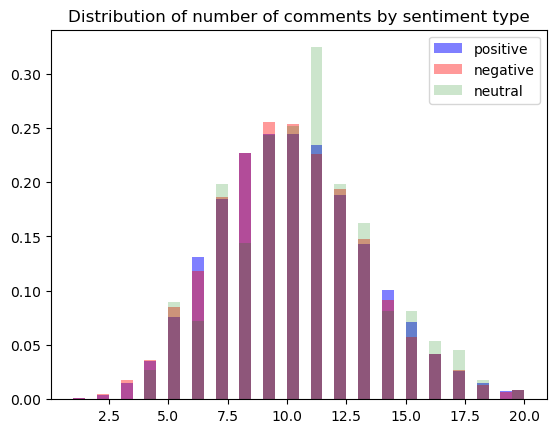

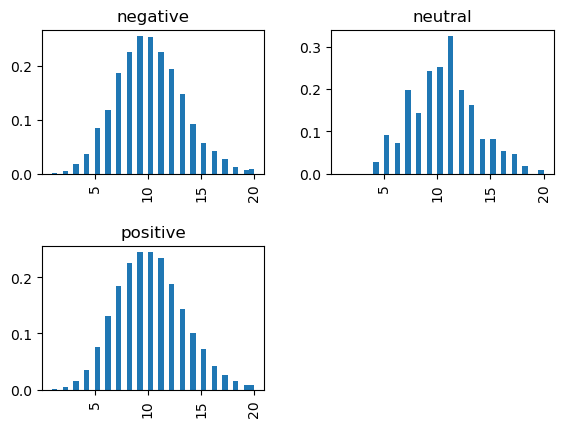

In [87]:
# 1. Does the sentiment of a post correlate with user engagement (as measured by num_comments)?

import statsmodels.api as sm
from statsmodels.formula.api import ols
model_sentiment = ols ('num_comments ~ sentiment', data=df_filtered).fit()
print(model_sentiment.summary())

# The sentiment of a post is correlate with user engagement.
#Posts with a positive sentiment tend to receive approximately 0.08 more comments
#relative to those with a negative sentiment (statistically significant in 0.05 level).

#Posts with a netural sentiment tend to receive approximately 0.47 more comments
#relative to those with a negative sentiment (statistically significant in 0.1 level).

import seaborn as sns
import matplotlib.pyplot as plt

pos_df = df_filtered[df_filtered['sentiment'] == 'positive']['num_comments']
neg_df = df_filtered[df_filtered['sentiment'] == 'negative']['num_comments']
neu_df = df_filtered[df_filtered['sentiment'] == 'neutral']['num_comments']

# histogram overlay
fig = plt.figure()
ax = fig.add_subplot(111)
bin_width = 0.5
ax.hist(pos_df, ls='dashed', alpha = 0.5, lw=3, color= 'b',
        density = True, bins=np.arange(1, max(pos_df) +  bin_width, bin_width))
ax.hist(neg_df, ls='dotted', alpha = 0.4, lw=3, color= 'r',
        density = True, bins=np.arange(1, max(neg_df) +  bin_width, bin_width))
ax.hist(neu_df, alpha = 0.2, lw=3, color= 'g', density = True,
        bins=np.arange(1, max(neu_df) +  bin_width, bin_width))
ax.legend(['positive', 'negative', 'neutral'])
plt.title("Distribution of number of comments by sentiment type")

# separate histograms for each group
df_filtered['num_comments'].hist(by = df_filtered['sentiment'],
                                 density = True,
                                 bins=np.arange(1, max(df_filtered['num_comments']) + bin_width, bin_width))


In [85]:
# 2. Do posts written in the first person receive more engagement (as measured by num_comments)
# compared to other posts. Please use a boolean variable indicating first-person narratives.

model_first_person = ols ('num_comments ~ first_person', data=df_filtered).fit()
print(model_first_person.summary())

# Posts written in the first person receive are not more engagement compared to other
#posts, since the correlation estimates is not statistically significant.

                            OLS Regression Results                            
Dep. Variable:           num_comments   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.571
Date:                Fri, 14 Jun 2024   Prob (F-statistic):              0.210
Time:                        14:07:41   Log-Likelihood:                -70619.
No. Observations:               27477   AIC:                         1.412e+05
Df Residuals:                   27475   BIC:                         1.413e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.0551 

                            OLS Regression Results                            
Dep. Variable:           num_comments   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9158
Date:                Fri, 14 Jun 2024   Prob (F-statistic):              0.432
Time:                        14:09:01   Log-Likelihood:                -70618.
No. Observations:               27477   AIC:                         1.412e+05
Df Residuals:                   27473   BIC:                         1.413e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.93

/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/494372328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time'] = pd.to_datetime(df_filtered['created_utc'], unit='s')
/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/494372328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hour'] = df_filtered['time'].dt.hour
/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/494372328.py:18: SettingWithCopyWarning: 
A value is trying to be se

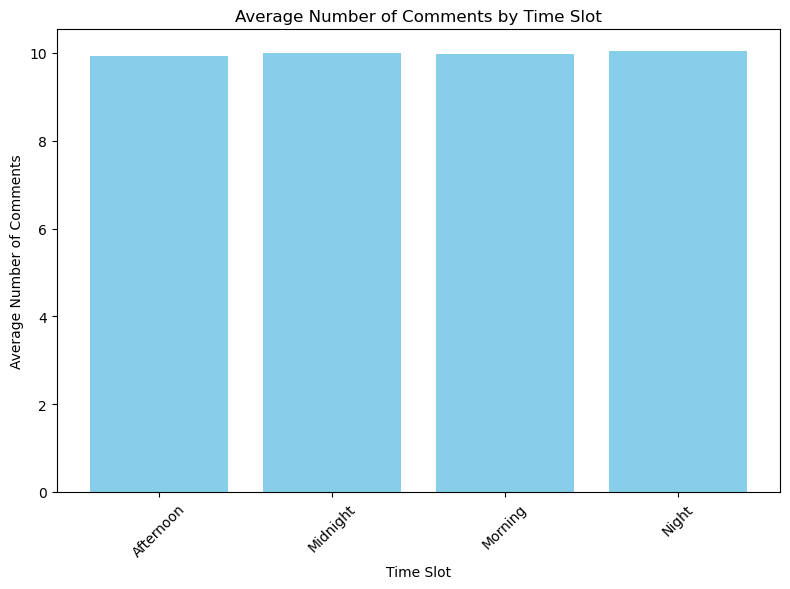

In [88]:
# 3. Does the time of day that a post is posted (using created_utc) influence the engagement as
# measured by num_comments) with the post. 

# Convert timestamp to datetime format
df_filtered['time'] = pd.to_datetime(df_filtered['created_utc'], unit='s')
df_filtered['hour'] = df_filtered['time'].dt.hour
# Define function to categorize hours into time slots
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Night'
    else:
        return 'Midnight'

df_filtered['time_slot'] = df_filtered['hour'].apply(categorize_time).astype('category')

model_time = ols ('num_comments ~ time_slot', data=df_filtered).fit()
print(model_time.summary())

# The time of day that a post is posted influence the engagement.
#Posts posted at night (17:00-21:00) tend to receive approximately 0.10 more
#comments relative to posts posted in the afternoon (statistically significant in 0.1 level).
#However, posts posted in other time slots (morning. midnight) do not influence the engagement, since
#the coefficients are not statistically significant.

time_slot_avg_comments = df_filtered.groupby('time_slot')['num_comments'].mean()

# Convert the series to a DataFrame
df_avg_comments = time_slot_avg_comments.reset_index(name='avg_comments')

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(df_avg_comments['time_slot'], df_avg_comments['avg_comments'], color='skyblue')
plt.title('Average Number of Comments by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Average Number of Comments')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [ ]:
# Step 5. Inference

In [89]:
# 1. Create a random variable indicating treatment status. A post can be considered treated if the
# final digit of the timestamp is less than 5.

df_filtered['treated'] = df_filtered['created_utc'].astype(str).str[-1].astype(int) < 5
df_filtered['time'] = pd.to_datetime(df_filtered['created_utc'], unit='s')
df_filtered['hour'] = df_filtered['time'].apply(lambda x:x.hour).astype('category')


# 2. Run the appropriate regression to determine if being assigned to this imaginary treatment impacted
# the length of a post.

df_filtered['length_text'] = df_filtered['body'].apply(len)
model_treated = ols ('length_text ~ treated', data=df_filtered).fit()
print(model_treated.summary())

# Being assigned to the imaginary treatment does not impact the length of a post,
# since the correlation estimates is not statistically significant.


                            OLS Regression Results                            
Dep. Variable:            length_text   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3368
Date:                Fri, 14 Jun 2024   Prob (F-statistic):              0.562
Time:                        14:09:51   Log-Likelihood:            -2.1020e+05
No. Observations:               27477   AIC:                         4.204e+05
Df Residuals:                   27475   BIC:                         4.204e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         681.6004      4.329    1

/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3247587166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['treated'] = df_filtered['created_utc'].astype(str).str[-1].astype(int) < 5
/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3247587166.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time'] = pd.to_datetime(df_filtered['created_utc'], unit='s')
/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/3247587166.py:6: SettingWith

In [90]:
# 3. Run the appropriate regression to determine if being assigned to this imaginary treatment impacted
# the likelihood that the post is a first person narrative.

df_filtered['first_person'] = df_filtered['body'].apply(detect_first_person).astype(int)
model_treatment = ols ('first_person ~ treated', data=df_filtered).fit()
print(model_treatment.summary())

# Being assigned to the imaginary treatment does not impact the likelihood that the post
#is a first person narrative, since the correlation estimates is not statistically significant.


                            OLS Regression Results                            
Dep. Variable:           first_person   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2699
Date:                Fri, 14 Jun 2024   Prob (F-statistic):              0.603
Time:                        14:10:15   Log-Likelihood:                -6270.4
No. Observations:               27477   AIC:                         1.254e+04
Df Residuals:                   27475   BIC:                         1.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8960      0.003    3

/var/folders/1k/fnmmddrx2wj79wvs4csc884w0000gn/T/ipykernel_47999/2220020738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['first_person'] = df_filtered['body'].apply(detect_first_person).astype(int)
